# MAT dSTRF crcns fit

This script fits crcns data to a dSTRF model composed of the augmented MAT model and a cosine basis STRF.

In [30]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
from models import cosstrf, mat, dstrf_mat

from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

## Setting paramters and loading data

In [31]:
# assimilation parameters
nwalkers = 1000
burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# dstrf model settings
free_ts = False
scale = 10
channels = 1
ncos = 30
coslin = 100
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# setup cosine basis
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True,norm=True)

# load data from crcns
cell = "yg0616_9_B"
stim_type = "conspecific"

stims,durations,spikes_data,spiky_data = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)
psth_data = [utils.psth(spk,dur,t_dsample,dsample=t_dsample) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.34


## Getting initial guess for STRF

In [32]:
# estimate STRF using elastic net regression
fit_psth = [p*1000 for p in assim_psth]
#fit_psth = [normalize(p,False) for p in assim_psth]

STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=False)
SPEC,TIM = utils.factorize(STRF_GUESS,channels)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

In [33]:
hyp = utils.hyper_opt(assim_stims,assim_psth,STRF_GUESS,nspec,tlen,norm=norm,center=center)
channels, ncos, coslin = hyp.search()

# setup cosine basis
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True,norm=True)
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

0.598296035103


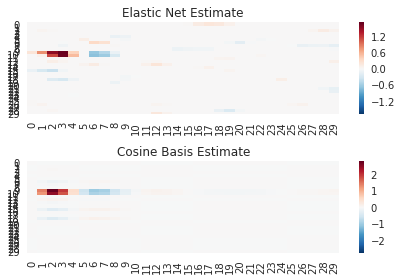

In [34]:
# plot elastic net and cosine estimate
subplot(211)
title("Elastic Net Estimate")
sns.heatmap(STRF_GUESS)

subplot(212)
title("Cosine Basis Estimate")
strf_model = cosstrf(channels,nspec,tlen,ncos,coslin,normalize=norm,center=center)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

tight_layout()
print(utils.evaluate(strf_model.filt,test_stims,test_psth))

## Define loss and prior functions

In [35]:
from neurofit import priors
from neurofit import costs

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    dist = 1000*np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    return dist

mat_prior = priors.joint_independent(
                [ nf.priors.uniform(-1000,  1000),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -1000,  1000)])

cost = spike_distance
unbounded = priors.unbounded()

def dstrf_shrink_prior(theta):
    return -np.sum(np.abs(theta[:-4])) + mat_prior(theta[-4:])

## Run initial MAT parameter fit

In [36]:
from neurofit import startpos

# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the mat model
mat_model = mat(free_ts=free_ts)

# generate starting positions of emcee walkers
p0 = startpos.uniform_independent(nwalkers,[-100,-10,-10,-10],[100,10,10,10])
#p0 = startpos.normal_independent(nwalkers,[10,1,0.1,1],[0.1]*4)

# run emcee
mat_smplr = nf.sampler(mat_model,mat_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),8)

for pos,_,_ in tracker(mat_smplr.sample(p0,iterations=burn)): continue
mat_smplr.reset()
mat_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -3562.1     0:02:31     0:23:01
   200     -3513.7     0:04:42     0:18:55
   300     -3507.6     0:06:52     0:16:06
   400     -3504.7     0:09:00     0:13:33
   500     -3503.1     0:11:06     0:11:09
   600     -3502.2     0:13:13     0:08:50
   700     -3501.4     0:15:21     0:06:36
   800     -3501.1     0:17:38     0:04:26
   900     -3500.6     0:19:49     0:02:13
  1000     -3500.3     0:21:56     0:00:01
  1001     -3500.3     0:21:57     0:00:00


In [37]:
# check the performance of the fit mat model
mml = mat_smplr.flatchain[np.argmax(mat_smplr.flatlnprobability)]
mat_map = mat()
mat_map.set(mml)
mat_corr = []

param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d in zip(test_Iapp,test_psth,test_dur):
    trace,spikes = mat_map.run(i)
    mat_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    mat_corr.append(np.corrcoef(p,mat_psth)[0][1])
        
start = np.hstack((filt_start,mml))
print("Filt R: {:.3f}, MAT R: {:.3f}".format(param_corr,np.mean(mat_corr)))

Filt R: 0.560, MAT R: 0.418


## Fit dSTRF model using emcee

In [38]:
# initalize the model
model = dstrf_mat(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center)

# set starting positions for walkers
p0 = startpos.normal_independent(nwalkers-1,start,[1e-4]*len(start))
p0 = np.vstack((start,p0))

# run emcee
dstrf_smplr = nf.sampler(model,dstrf_shrink_prior,spike_distance,nwalkers,zip(assim_stims,assim_spiky),8)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -4140.9     0:10:22     1:34:27
   200     -3988.8     0:18:15     1:13:27
   300     -3927.5     0:26:05     1:01:11
   400     -3887.8     0:37:35     0:56:36
   500     -3852.7     0:49:06     0:49:18
   600     -3826.2     1:00:43     0:40:39
   700     -3804.5     1:12:26     0:31:11
   800     -3787.7     1:23:22     0:20:58
   900     -3773.6     1:30:54     0:10:12
  1000     -3762.8     1:38:29     0:00:05
  1001     -3762.7     1:38:34     0:00:00


## Evaluate the model fit

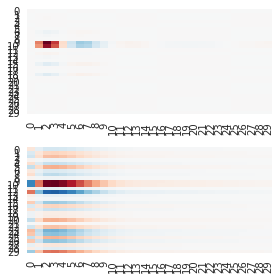

In [39]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))

# compare EN and dstrf STRFs
subplot(211)
sns.heatmap(strf_model.filt,cbar=False)

subplot(212)
sns.heatmap(model.pstrf.filt,cbar = False)
tight_layout()

In [ ]:
map_corr = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,t_dsample,psth_smooth)
ppcorr = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth,ntrials=100)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)

print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))


MAP: 0.38, Dist: 0.48, EO: 0.34
MAP/EO: 1.09, Dist/EO: 1.40


In [ ]:
from corner import corner

matlabs = ['a','b','c','w']
corner(dstrf_smplr.flatchain[:,-4:],
       range=[[-100,100],
              [-10,10],
              [-10,10],
              [-100,100]],
       bins=50, smooth=2,mooth1d=5,
       labels=matlabs);

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/corner/corner.py:532: RuntimeWarning: invalid value encountered in divide
  sm /= sm[-1]
/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/corner/corner.py:536: RuntimeWarning: invalid value encountered in less_equal
  V[i] = Hflat[sm <= v0][-1]
